## Fonctions pour projet

need to normalize data ? (cf Dissecting financial markets: Sectors and states) (on devrait utiliser les returns donc pas trop besoin de normaliser)
- si on cluster les assets, logiquement la correlation/covariance entre chaque cluster devrait être négative/nulle (parce que la distance serait sans doute la covariance entre les assets), du coup faire une stratégie qui investit dans un représentant (asset ou weigted average) de chaque cluster devrait réduire le risque/volatilité du portfolio (problème étant que on aurait pas un zero-cost portfolio), ou alors prédire le signe de return de chaque cluster à la prochaine période et donc investir en fonction)
- si on cluster par jour/période de temps, l'idée serait de prédire le futur état et pour chaque état définir une méthode d'investissement
- https://d-nb.info/1108447864/34 papier qui parle de cluster les assets: truc important à noter est que les weights pour chaque cluster sont définis par hierarchical clustering p47-48, et les clusters/weights sont recalculés tous les 130 jours (permet d'éviter de refaire les clusters à chaque fois, et en pls ne suppose plus que les clusters restent les memes)

In [1]:

#Pour faire des clusters
#ce qui doit etre cluster sont les colonnes du dataframe (donc si on veut cluster les dates il faut transposer la matrice)


from numpy import linalg as LA
import numpy as np
import pandas as pd
import math
import networkx as nx
import community

#Idea is to remove low eigenvalues that are considered as noise
def compute_C_minus_C0(lambdas,v,lambda_plus,removeMarketMode=True): 
    N=len(lambdas)
    C_clean=np.zeros((N, N))
    
    order = np.argsort(lambdas)
    lambdas,v = lambdas[order],v[:,order]
    
    v_m=np.matrix(v)

    # note that the eivenvalues are sorted
    for i in range(1*removeMarketMode,N):                            
        if lambdas[i]>lambda_plus: 
            C_clean=C_clean+lambdas[i] * np.dot(v_m[:,i],v_m[:,i].T)  
    return C_clean    
    
    
def LouvainCorrelationClustering(R):   # R is a matrix of return
    N=R.shape[1]
    T=R.shape[0]

    q=N*1./T
    lambda_plus=(1.+np.sqrt(q))**2

    C=R.corr()
    lambdas, v = LA.eigh(C)


            
    C_s=compute_C_minus_C0(lambdas,v,lambda_plus)
    
    mygraph= nx.from_numpy_matrix(np.abs(C_s))
    partition = community.community_louvain.best_partition(mygraph,random_state=29)

    DF=pd.DataFrame.from_dict(partition,orient="index",columns=['Cluster'])
    DF.index=R.columns
    return(DF)





peut etre qu'on peut faire une analyse des eigenvalues et eigenvectors (cf cours 9-10)
mais la question est qu'on peut pas faire les eigenvalues sur tout le dataset (parce que dans ce cas on analyserait le futur avant meme de faire des clusters par exemple...)

De plus, cf cours 11 on pourrait faire varier les méthodes de cluster, que ce soit en changeant la facon de faire le cluster ou de changer le critère qui doit être cluster (return, sign of return, excess return ...)

et faudrait aussi du coup faire des investment strategies et les comparer entre elles, et avec un benchmark

In [210]:
#Creer un rolled clustering 
#(Suppose que l'index du dataframe est simplement des valeurs et non des dates)-> normalement mtn c bon pour tout
#Check si le cluster a pas déjà été fait et sauvegardé
#Si non il fait le cluster et le sauvegarde (économie de temps)

from os.path import exists
import os
from fastparquet import write, ParquetFile

def get_Louvain_cluster(R,filename,t_0,t_1) : #Check if we already have the clustering or not and compute louvain cluster
    if(exists(filename) and os.path.getsize(filename)>0):
        DF=pd.read_parquet(filename)
    else:
        rolling_data=R.iloc[(R.index>=t_0) & (R.index<t_1)]
        rolling_data=rolling_data.T
        DF= LouvainCorrelationClustering(rolling_data)
        DF.to_parquet(filename)
    return(DF)

#R is matrix of return
#cluster_period is the period over we cluster
#day_state is to know if we have to transpose matrix to cluster periods instead of assets
#lag in "if" is the number of time we cluster
#keep_all_info is if we would like to roll the clusters but keep all information from the beginning of data 
#or just keep the same window length
def RolledCluster(R, cluster_period, filepath, day_state=False, keep_all_info=False):
    liste=[]
    if keep_all_info: 
        if day_state :
            for lag in range(1,20):  #on va devoir changer le range pour le projet mais la c'est pour tester
                t_0=R.index[0]
                t_1=R.index[0+lag+cluster_period]    
                filename=filepath+"/louvain_cluster/{}_{}_cluster_day_keep_all_info.parquet".format(t_0,t_1)
                DF= get_Louvain_cluster(R,filename,t_0,t_1)
                liste.append(DF)
        else :
            for lag in range(1,20):  #on va devoir changer le range pour le projet mais la c'est pour tester
                t_0=R.index[0]
                t_1=R.index[0+lag+cluster_period]    
                filename=filepath+"/louvain_cluster/{}_{}_cluster_keep_all_info.parquet".format(t_0,t_1)
        
                DF= get_Louvain_cluster(R,filename,t_0,t_1)
                liste.append(DF)
    else : 
        if day_state :
            for lag in range(1,20):  #on va devoir changer le range pour le projet mais la c'est pour tester
                t_0=R.index[0+lag]
                t_1=R.index[0+lag+cluster_period]    
                filename=filepath+"/louvain_cluster/{}_{}_cluster_day.parquet".format(t_0,t_1)
                DF= get_Louvain_cluster(R,filename,t_0,t_1)
                liste.append(DF)
        else :
            for lag in range(1,20):  #on va devoir changer le range pour le projet mais la c'est pour tester
                t_0=R.index[0+lag]
                t_1=R.index[0+lag+cluster_period]    
                filename=filepath+"/louvain_cluster/{}_{}_cluster.parquet".format(t_0,t_1)
        
                DF= get_Louvain_cluster(R,filename,t_0,t_1)
                liste.append(DF)
    return(liste)

#Renvoie une liste de clusters
#Choose the assets (thus N ), choose the calibration length 
#(T = N/3 is a good choice for market states, T = 3N is a good choice for asset classification)

In [3]:
#Compute the rolling ARI of the clusters
from sklearn import metrics

def RolledARI(liste):
    ARI=[]
    for element in range(0, len(liste)-1):
        new_df=pd.merge(liste[element], liste[element+1], left_index=True, right_index=True)
        ARI.append(metrics.adjusted_rand_score(new_df["Cluster_x"], new_df["Cluster_y"]))
    return(ARI)

In [4]:
#fonction qu'on avait fait mais pas sur que ca serve dans notre cas
def compute_R(events,tau_max=1000,dtau=1):
    taus=range(1,tau_max,dtau)
    
    ## insert code here
    R=[-(events["mid"].diff(-tau)*events["s"]).mean() for tau in taus]
    
    
    return np.array(R)

def compute_R_h(events):
    R=pd.pivot_table(events.groupby(events.index.hour).apply(compute_R).apply(pd.Series), columns=events.groupby(events.index.hour).apply(compute_R).apply(pd.Series).index)
    return (R)

# Pour run les fonctions et les tester

In [5]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
logret= pd.read_parquet("/Users/mrobaux/Desktop/Financial big data/data/clean/equities/daily/us-stocks/us_logret.parquet")


new_logret=logret.loc[logret.index>10000]
new_logret= new_logret.loc[new_logret.index<16000]
dropcol = new_logret.loc[:,new_logret.isna().sum(axis=0)>0].columns
new_logret=new_logret.drop(columns=dropcol)

In [252]:
lii= RolledCluster(new_logret,200,"/Users/mrobaux/Desktop/Financial big data/projet",True,False)
a=RolledARI(lii)
number_of_clusters=[]
for element in lii:
    number_of_clusters.append(element["Cluster"].unique().max()+1)

In [65]:
#rename clusters based on similarity
#pour linstant renvoie simplement une matrice de similarite
#l'entree (i,j) correspond au pourcentage d'éléments du cluster 2j qui appartiennent aussi au cluster 1i
def keep_cluster_number(cluster1,cluster2):
    n=cluster1["Cluster"].unique().max()
    m=cluster2["Cluster"].unique().max()
    cst=10000 #pour éviter de changer deux fois les indices plus tard
    matrix = np.zeros((n+1,m+1))
    for i in range(n+1):
        for j in range(m+1):
            merged=pd.merge(cluster1,cluster2, left_index=True, right_index=True)
            num= len(merged[(merged["Cluster_y"]==j) & (merged["Cluster_x"]==i)])
            denom=len(merged[(merged["Cluster_y"]==j)])
            matrix[i][j]= num/denom
    tmp=cluster2.copy(deep=True) 
    for j in range(m+1): #Now change cluster number according to similarity
        value_cluster= np.where(matrix==np.amax(matrix,0))[1][j]
        tmp[tmp["Cluster"]==j]= (value_cluster+cst)
    tmp=tmp-cst
    return(tmp)
    

In [105]:
#One time prediction of cluster belonging
#lines = state t
#col = state t+1
def one_step_pred(cluster):
    m=cluster["Cluster"].unique().max()
    matrix = np.zeros((m+1,m+1))
    for p in range(len(cluster)-1):
        i=cluster["Cluster"].iloc[p]
        tmp=p+1
        j=cluster["Cluster"].iloc[tmp]
        matrix[i][j]=matrix[i][j]+1  #Counts number of times when you go from state i to state j
    matrix=matrix/(len(cluster)-1)
    return(matrix)

In [233]:
for i in range(len(lii)-1):
    lii[i+1]=keep_cluster_number(lii[i],lii[i+1])



In [272]:
matrix

array([[0.05405405, 0.04054054, 0.01351351, 0.05405405],
       [0.02702703, 0.09459459, 0.12162162, 0.05405405],
       [0.05405405, 0.09459459, 0.12162162, 0.05405405],
       [0.01351351, 0.06756757, 0.08108108, 0.05405405]])

In [182]:
#Create sankey plot
#!pip install plotly

import plotly.graph_objects as go
label = ["Cluster 0","Cluster 1","Cluster 2","Cluster 3","Cluster 0","Cluster 1","Cluster 2","Cluster 3","Cluster 0","Cluster 1","Cluster 2","Cluster 3","Cluster 0","Cluster 1","Cluster 2","Cluster 3"]
source = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8,8]
target =[4,5,6,7,4,5,6,7,4,5,6,7,4,5,6,7,8,9,10,11,8,9,10,11,8,9,10,11,8,9,10,11]
value = [matrix[0][0],matrix[0][1],matrix[0][2],matrix[0][3],matrix[1][0],matrix[1][1],matrix[1][2],matrix[1][3],matrix[2][0],matrix[2][1],matrix[2][2],matrix[2][3],matrix[3][0],matrix[3][1],matrix[3][2],matrix[3][3],matrix1[0][0],matrix1[0][1],matrix1[0][2],matrix1[0][3],matrix1[1][0],matrix1[1][1],matrix1[1][2],matrix1[1][3],matrix1[2][0],matrix1[2][1],matrix1[2][2],matrix1[2][3],matrix1[3][0],matrix1[3][1],matrix1[3][2],matrix1[3][3]]
link=dict(source=source,target=target,value=value)
node= dict(label=label,pad=35, thickness=10)


data=go.Sankey(link=link, node=node)


In [183]:
go.Figure(data)

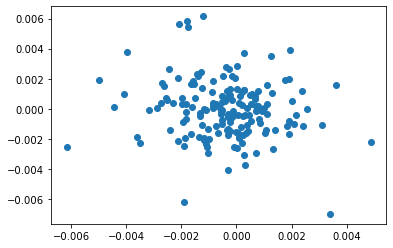

In [255]:
test=lii[8]
index0= test[test["Cluster"]==1].index
index1= test[test["Cluster"]==2].index


mean0=new_logret.loc[index0].mean()
mean1=new_logret.loc[index1].mean()

plt.scatter(mean0,mean1)


In [265]:
import yfinance as yf
import datetime
import time
import requests
import io

start = datetime.datetime(2010,2,1)
end = datetime.datetime(2020,10,11)


url="https://pkgstore.datahub.io/core/nasdaq-listings/nasdaq-listed_csv/data/7665719fb51081ba0bd834fde71ce822/nasdaq-listed_csv.csv"
s = requests.get(url).content
companies = pd.read_csv(io.StringIO(s.decode('utf-8')))

Symbols = companies['Symbol'].tolist()

# create empty dataframe
stock_final = pd.DataFrame()
# iterate over each symbol
for i in Symbols:  
    
    # print the symbol which is being downloaded
    print( str(Symbols.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    
    try:
        # download the stock price 
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False)
        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['Name']=i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None

0 : AAIT,1 : AAL,2 : AAME,3 : AAOI,4 : AAON,5 : AAPL,6 : AAVL,7 : AAWW,8 : AAXJ,9 : ABAC,
1 Failed download:
- ABAC: No data found for this date range, symbol may be delisted
10 : ABAX,11 : ABCB,12 : ABCD,13 : ABCO,14 : ABCW,
1 Failed download:
- ABCW: No data found for this date range, symbol may be delisted
15 : ABDC,
1 Failed download:
- ABDC: No data found, symbol may be delisted
16 : ABGB,
1 Failed download:
- ABGB: No data found for this date range, symbol may be delisted
17 : ABIO,18 : ABMD,19 : ABTL,
1 Failed download:
- ABTL: No data found for this date range, symbol may be delisted
20 : ABY,
1 Failed download:
- ABY: No data found for this date range, symbol may be delisted
21 : ACAD,22 : ACAS,
1 Failed download:
- ACAS: No data found for this date range, symbol may be delisted
23 : ACAT,
1 Failed download:
- ACAT: No data found for this date range, symbol may be delisted
24 : ACET,25 : ACFC,26 : ACFN,27 : ACGL,28 : ACHC,29 : ACHN,
1 Failed download:
- ACHN: Data doesn't exis

212 : ASBI,
1 Failed download:
- ASBI: No data found for this date range, symbol may be delisted
213 : ASCMA,
1 Failed download:
- ASCMA: No data found, symbol may be delisted
214 : ASEI,
1 Failed download:
- ASEI: No data found for this date range, symbol may be delisted
215 : ASFI,
1 Failed download:
- ASFI: No data found, symbol may be delisted
216 : ASMB,217 : ASMI,
1 Failed download:
- ASMI: No data found for this date range, symbol may be delisted
218 : ASML,219 : ASNA,
1 Failed download:
- ASNA: No data found, symbol may be delisted
220 : ASPS,221 : ASPX,
1 Failed download:
- ASPX: No data found for this date range, symbol may be delisted
222 : ASRV,223 : ASRVP,
1 Failed download:
- ASRVP: No data found, symbol may be delisted
224 : ASTC,225 : ASTE,226 : ASTI,227 : ASUR,228 : ASYS,229 : ATAI,
1 Failed download:
- ATAI: Data doesn't exist for startDate = 1264978800, endDate = 1602367200
230 : ATAX,231 : ATEA,
1 Failed download:
- ATEA: No data found, symbol may be delisted
232 : 

430 : CAMP,431 : CAMT,432 : CAPN,
1 Failed download:
- CAPN: None
433 : CAPNW,
1 Failed download:
- CAPNW: No data found, symbol may be delisted
434 : CAR,435 : CARA,436 : CARB,
1 Failed download:
- CARB: No data found, symbol may be delisted
437 : CARO,
1 Failed download:
- CARO: No data found, symbol may be delisted
438 : CART,
1 Failed download:
- CART: No data found, symbol may be delisted
439 : CARV,440 : CARZ,441 : CASH,442 : CASI,443 : CASM,
1 Failed download:
- CASM: No data found, symbol may be delisted
444 : CASS,445 : CASY,446 : CATM,
1 Failed download:
- CATM: No data found, symbol may be delisted
447 : CATY,448 : CATYW,
1 Failed download:
- CATYW: No data found, symbol may be delisted
449 : CAVM,450 : CBAK,
1 Failed download:
- CBAK: None
451 : CBAN,452 : CBAY,453 : CBDE,
1 Failed download:
- CBDE: No data found, symbol may be delisted
454 : CBF,
1 Failed download:
- CBF: None
455 : CBFV,456 : CBIN,
1 Failed download:
- CBIN: None
457 : CBLI,
1 Failed download:
- CBLI: No 

699 : CTSH,700 : CTSO,701 : CTWS,
1 Failed download:
- CTWS: No data found, symbol may be delisted
702 : CTXS,703 : CU,
1 Failed download:
- CU: None
704 : CUBA,705 : CUI,
1 Failed download:
- CUI: No data found, symbol may be delisted
706 : CUNB,
1 Failed download:
- CUNB: None
707 : CUTR,708 : CVBF,709 : CVCO,710 : CVCY,711 : CVGI,712 : CVGW,713 : CVLT,714 : CVLY,715 : CVTI,
1 Failed download:
- CVTI: No data found, symbol may be delisted
716 : CVV,717 : CWAY,718 : CWBC,719 : CWCO,720 : CWST,721 : CXDC,722 : CY,
1 Failed download:
- CY: No data found, symbol may be delisted
723 : CYAN,724 : CYBE,725 : CYBR,726 : CYBX,
1 Failed download:
- CYBX: None
727 : CYCC,728 : CYCCP,729 : CYHHZ,
1 Failed download:
- CYHHZ: No data found, symbol may be delisted
730 : CYNO,
1 Failed download:
- CYNO: None
731 : CYOU,
1 Failed download:
- CYOU: No data found, symbol may be delisted
732 : CYRN,733 : CYTK,734 : CYTR,735 : CYTX,
1 Failed download:
- CYTX: No data found, symbol may be delisted
736 : C

982 : FCVA,
1 Failed download:
- FCVA: None
983 : FCZA,
1 Failed download:
- FCZA: None
984 : FCZAP,
1 Failed download:
- FCZAP: No data found, symbol may be delisted
985 : FDEF,
1 Failed download:
- FDEF: No data found, symbol may be delisted
986 : FDIV,987 : FDML,
1 Failed download:
- FDML: None
988 : FDUS,989 : FEIC,
1 Failed download:
- FEIC: None
990 : FEIM,991 : FELE,992 : FEMB,993 : FES,
1 Failed download:
- FES: None
994 : FEUZ,995 : FEYE,
1 Failed download:
- FEYE: No data found, symbol may be delisted
996 : FFBC,997 : FFBCW,
1 Failed download:
- FFBCW: No data found, symbol may be delisted
998 : FFHL,999 : FFIC,1000 : FFIN,1001 : FFIV,1002 : FFKT,1003 : FFNM,1004 : FFNW,1005 : FFWM,1006 : FGEN,1007 : FHCO,
1 Failed download:
- FHCO: None
1008 : FIBK,1009 : FINL,1010 : FISH,
1 Failed download:
- FISH: None
1011 : FISI,1012 : FISV,1013 : FITB,1014 : FITBI,1015 : FIVE,1016 : FIVN,1017 : FIZZ,1018 : FLAT,1019 : FLDM,1020 : FLEX,1021 : FLIC,1022 : FLIR,
1 Failed download:
- FLIR: 

1238 : HCACW,
1 Failed download:
- HCACW: No data found, symbol may be delisted
1239 : HCAP,
1 Failed download:
- HCAP: No data found, symbol may be delisted
1240 : HCBK,
1 Failed download:
- HCBK: None
1241 : HCCI,1242 : HCKT,1243 : HCOM,
1 Failed download:
- HCOM: Data doesn't exist for startDate = 1264978800, endDate = 1602367200
1244 : HCSG,1245 : HCT,
1 Failed download:
- HCT: None
1246 : HDNG,1247 : HDP,1248 : HDRA,
1 Failed download:
- HDRA: None
1249 : HDRAR,
1 Failed download:
- HDRAR: No data found, symbol may be delisted
1250 : HDRAU,
1 Failed download:
- HDRAU: No data found, symbol may be delisted
1251 : HDRAW,
1 Failed download:
- HDRAW: No data found, symbol may be delisted
1252 : HDS,
1 Failed download:
- HDS: No data found, symbol may be delisted
1253 : HDSN,1254 : HEAR,1255 : HEES,1256 : HELE,1257 : HEOP,
1 Failed download:
- HEOP: None
1258 : HERO,1259 : HFBC,
1 Failed download:
- HFBC: No data found, symbol may be delisted
1260 : HFBL,1261 : HFFC,
1 Failed download:

1493 : KCAP,
1 Failed download:
- KCAP: No data found, symbol may be delisted
1494 : KCLI,1495 : KE,1496 : KELYA,1497 : KELYB,1498 : KEQU,1499 : KERX,1500 : KEYW,1501 : KFFB,1502 : KFRC,1503 : KFX,
1 Failed download:
- KFX: No data found for this date range, symbol may be delisted
1504 : KGJI,1505 : KIN,
1 Failed download:
- KIN: No data found, symbol may be delisted
1506 : KINS,1507 : KIRK,1508 : KITE,
1 Failed download:
- KITE: No data found for this date range, symbol may be delisted
1509 : KLAC,1510 : KLIC,1511 : KLXI,1512 : KMDA,1513 : KNDI,1514 : KONA,
1 Failed download:
- KONA: No data found, symbol may be delisted
1515 : KONE,
1 Failed download:
- KONE: No data found for this date range, symbol may be delisted
1516 : KOOL,
1 Failed download:
- KOOL: No data found, symbol may be delisted
1517 : KOPN,1518 : KOSS,1519 : KPTI,1520 : KRFT,
1 Failed download:
- KRFT: No data found for this date range, symbol may be delisted
1521 : KRNY,1522 : KTCC,1523 : KTEC,
1 Failed download:
- KT

1717 : MIDD,1718 : MIFI,
1 Failed download:
- MIFI: None
1719 : MIK,
1 Failed download:
- MIK: No data found, symbol may be delisted
1720 : MIND,1721 : MINI,
1 Failed download:
- MINI: No data found, symbol may be delisted
1722 : MITK,1723 : MITL,1724 : MKSI,1725 : MKTO,
1 Failed download:
- MKTO: None
1726 : MKTX,1727 : MLAB,1728 : MLHR,
1 Failed download:
- MLHR: No data found, symbol may be delisted
1729 : MLNK,
1 Failed download:
- MLNK: Data doesn't exist for startDate = 1264978800, endDate = 1602367200
1730 : MLNX,
1 Failed download:
- MLNX: No data found, symbol may be delisted
1731 : MLVF,1732 : MMAC,
1 Failed download:
- MMAC: No data found, symbol may be delisted
1733 : MMLP,1734 : MMSI,1735 : MMYT,1736 : MNDL,
1 Failed download:
- MNDL: None
1737 : MNDO,1738 : MNGA,
1 Failed download:
- MNGA: No data found, symbol may be delisted
1739 : MNKD,1740 : MNOV,1741 : MNRK,
1 Failed download:
- MNRK: None
1742 : MNRO,1743 : MNST,1744 : MNTA,
1 Failed download:
- MNTA: No data found,

1978 : OXFD,
1 Failed download:
- OXFD: No data found, symbol may be delisted
1979 : OXGN,
1 Failed download:
- OXGN: None
1980 : OXLC,1981 : OXLCN,
1 Failed download:
- OXLCN: No data found, symbol may be delisted
1982 : OXLCO,
1 Failed download:
- OXLCO: Data doesn't exist for startDate = 1264978800, endDate = 1602367200
1983 : OXLCP,1984 : OZRK,
1 Failed download:
- OZRK: No data found, symbol may be delisted
1985 : PAAS,1986 : PACB,1987 : PACW,1988 : PAGG,
1 Failed download:
- PAGG: None
1989 : PAHC,1990 : PANL,1991 : PARN,
1 Failed download:
- PARN: None
1992 : PATIV,
1 Failed download:
- PATIV: No data found, symbol may be delisted
1993 : PATK,1994 : PAYX,1995 : PBCP,
1 Failed download:
- PBCP: None
1996 : PBCT,1997 : PBHC,1998 : PBIB,
1 Failed download:
- PBIB: None
1999 : PBIP,2000 : PBMD,
1 Failed download:
- PBMD: None
2001 : PBPB,2002 : PBSK,2003 : PCAR,2004 : PCBK,
1 Failed download:
- PCBK: None
2005 : PCCC,
1 Failed download:
- PCCC: None
2006 : PCH,2007 : PCLN,
1 Failed 

2240 : RFIL,2241 : RGCO,2242 : RGDO,
1 Failed download:
- RGDO: No data found, symbol may be delisted
2243 : RGDX,
1 Failed download:
- RGDX: No data found for this date range, symbol may be delisted
2244 : RGEN,2245 : RGLD,2246 : RGLS,2247 : RGSE,
1 Failed download:
- RGSE: No data found, symbol may be delisted
2248 : RIBT,2249 : RIBTW,
1 Failed download:
- RIBTW: No data found, symbol may be delisted
2250 : RICK,2251 : RIGL,2252 : RITT,2253 : RITTW,
1 Failed download:
- RITTW: No data found, symbol may be delisted
2254 : RIVR,
1 Failed download:
- RIVR: No data found for this date range, symbol may be delisted
2255 : RJET,
1 Failed download:
- RJET: No data found for this date range, symbol may be delisted
2256 : RLJE,2257 : RLOC,
1 Failed download:
- RLOC: No data found for this date range, symbol may be delisted
2258 : RLOG,
1 Failed download:
- RLOG: No data found for this date range, symbol may be delisted
2259 : RLYP,
1 Failed download:
- RLYP: No data found for this date range,

2447 : SMTX,
1 Failed download:
- SMTX: No data found, symbol may be delisted
2448 : SNAK,
1 Failed download:
- SNAK: None
2449 : SNBC,
1 Failed download:
- SNBC: None
2450 : SNC,
1 Failed download:
- SNC: None
2451 : SNCR,2452 : SNDK,
1 Failed download:
- SNDK: None
2453 : SNFCA,2454 : SNHY,
1 Failed download:
- SNHY: No data found, symbol may be delisted
2455 : SNMX,2456 : SNPS,2457 : SNSS,
1 Failed download:
- SNSS: No data found, symbol may be delisted
2458 : SNTA,
1 Failed download:
- SNTA: None
2459 : SOCB,
1 Failed download:
- SOCB: None
2460 : SOCL,2461 : SODA,2462 : SOFO,2463 : SOHO,2464 : SOHOL,
1 Failed download:
- SOHOL: No data found, symbol may be delisted
2465 : SOHOM,
1 Failed download:
- SOHOM: No data found, symbol may be delisted
2466 : SOHU,2467 : SONA,
1 Failed download:
- SONA: No data found, symbol may be delisted
2468 : SONC,2469 : SONS,
1 Failed download:
- SONS: None
2470 : SORL,
1 Failed download:
- SORL: No data found, symbol may be delisted
2471 : SOXX,2472

2677 : TTEC,2678 : TTEK,2679 : TTGT,2680 : TTHI,
1 Failed download:
- TTHI: None
2681 : TTMI,2682 : TTOO,2683 : TTPH,
1 Failed download:
- TTPH: No data found, symbol may be delisted
2684 : TTS,
1 Failed download:
- TTS: No data found, symbol may be delisted
2685 : TTWO,2686 : TUBE,
1 Failed download:
- TUBE: None
2687 : TUES,
1 Failed download:
- TUES: No data found, symbol may be delisted
2688 : TUSA,2689 : TVIX,
1 Failed download:
- TVIX: No data found, symbol may be delisted
2690 : TVIZ,
1 Failed download:
- TVIZ: None
2691 : TWER,2692 : TWIN,2693 : TWMC,
1 Failed download:
- TWMC: No data found, symbol may be delisted
2694 : TWOU,2695 : TXN,2696 : TXRH,2697 : TYPE,
1 Failed download:
- TYPE: No data found, symbol may be delisted
2698 : TZOO,2699 : UACL,
1 Failed download:
- UACL: None
2700 : UAE,2701 : UBCP,2702 : UBFO,2703 : UBIC,
1 Failed download:
- UBIC: None
2704 : UBNK,
1 Failed download:
- UBNK: No data found, symbol may be delisted
2705 : UBNT,
1 Failed download:
- UBNT: N

2894 : WOOD,2895 : WOOF,
1 Failed download:
- WOOF: Data doesn't exist for startDate = 1264978800, endDate = 1602367200
2896 : WPCS,
1 Failed download:
- WPCS: No data found for this date range, symbol may be delisted
2897 : WPPGY,
1 Failed download:
- WPPGY: No data found for this date range, symbol may be delisted
2898 : WPRT,2899 : WRES,
1 Failed download:
- WRES: No data found for this date range, symbol may be delisted
2900 : WRLD,2901 : WSBC,2902 : WSBF,2903 : WSCI,2904 : WSFS,2905 : WSFSL,
1 Failed download:
- WSFSL: No data found, symbol may be delisted
2906 : WSTC,
1 Failed download:
- WSTC: No data found for this date range, symbol may be delisted
2907 : WSTG,2908 : WSTL,2909 : WTBA,2910 : WTFC,2911 : WTFCW,
1 Failed download:
- WTFCW: No data found, symbol may be delisted
2912 : WTSL,
1 Failed download:
- WTSL: No data found for this date range, symbol may be delisted
2913 : WVFC,2914 : WVVI,2915 : WWD,2916 : WWWW,
1 Failed download:
- WWWW: No data found for this date range

In [269]:
!pip install pydot
!pip install graphviz

     |████████████████████████████████| 46 kB 2.5 MB/s eta 0:00:01


In [342]:

states = ["0","1","2","3"]
def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

edges_wts = _get_markov_edges(prob_state_transitions)

# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(states)

# edges represent transition probabilities
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
#, prog='dot'
#nx.drawing.nx_pydot.write_dot(G,path=os.environ["PATH"])
pos = nx.drawing.nx_pydot.pydot_layout(G,prog="dot")
nx.draw_networkx(G, pos)

# create edge labels for jupyter plot but is not necessary
edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'pet_dog_markov.dot')

NotADirectoryError: [Errno 20] Not a directory: 'dot'

In [297]:
!pip3 install pydot-ng
import os
os.environ["PATH"] += os.pathsep + "/usr/bin/dot"

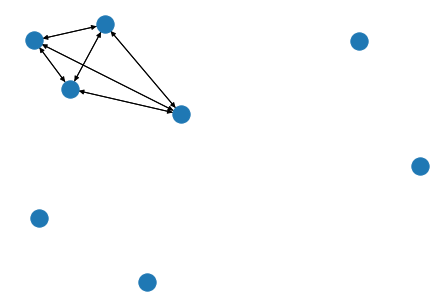

In [328]:
weigted_edges=[]
for i in range(4):
    for j in range(4):
        weigted_edges.append((i,j,prob_state_transitions[i][j]))


# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(states)
G.add_weighted_edges_from(weigted_edges)

nx.draw(G)